# uSEIR Model Kalman Filter

This NB :

 - presents the uSEIR model without and with social distances measures (quarentine)
 
 - Fit the data to a KF to compute the infection rate as a function of time
 
 - Shows that the distribution of deaths can be used as proxy for the infected

version: 2020/07/02
author : JAH, JJG


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.dates as mdates

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Thu Jul  2 12:29:47 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
import c19.useir            as us
import c19.useir_plot       as usp
#import c19.kfilter          as kf

import scipy          as sp
import scipy.stats    as stats

#from numpy.linalg import inv
#m_   = np.matmul
#npa  = np.array

## uSEIR

The uSEIR model has several cathegories: 
  - $S$ : Susceptible (initially the complete population), 
  - $E$ : Exposed (individals that have been infected but there are not still infectious), 
  - $I$ : Infected individuals with infections symtoms and contagious
  - $R$ : Recupeted (or Removal) individuals that have superated the infection or are in hospital, quarentened with no possibility to infect other people
  - $D$ : Death indivduals (not needed in the model, added by completion)

The main parameters of the model are:

  - $N$    : total number of the population
  - $\beta$ : number of new exposed iniivuals per day and per infectious, that is $R_0/T_R$, (1/day), before quanrentine or social distance measures.
  - $\rho$  : number of removed/recuperated individuals per day per infectious, that is $R_1/T_R$, (1/day), after quarentine or social distiance measures.
  - $T_I$   : Time from exposed to infected (days)
  - $T_R$   : Time from infected to removed/recuperated (days)
  - $T_M$   : Time from infected to death (days)
  - $\phi_M$: fraction of mortality of infected
  
Alternatively we can use:

  - $R_0$ : average number of exposed individuals per infected individual before social distance measures.
  - $R_1$ : average number of exposed individuals per infected individual after social distance measures
  
 The pdf are modeled using different pdfs:
 
  - delta, poisson, gamma, exponential, uniform, weibull
  
 


### Example of a pandemic evolution

Case of a million individuals, with $R_0 = 3$ and $T_I = 5, \; T_R = 5$ days. Mortality fraction, $\Phi_M = 0.05$, modeled with a gamma pdf.



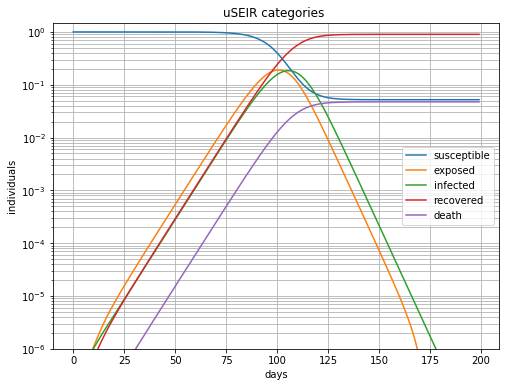

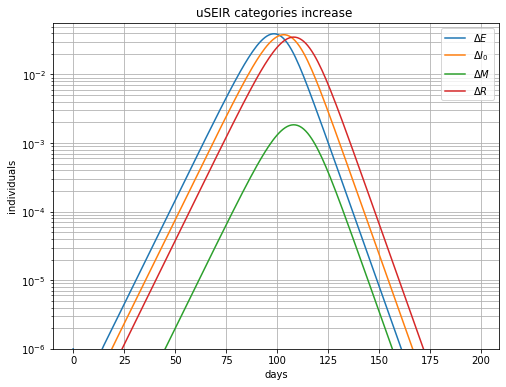

In [5]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 5.
PhiM            = 0.05
ndays           = 200
rho             = 'gamma'
frho            = us.frho(rho)
ts = np.arange(ndays)
SS, DS          = us.uSEIR(N, R0, TI, TR, TM, PhiM, ndays, rho = rho)

# the arrays:
S, E, I, R, M   = SS
DE, DI0, DR, DM = DS

usp.plt_uSEIR(ts, SS, DS, norma = True)

### generate data

Fluctuate the number of new infections, recovered and death per day according to poisson $\sqrt{\Delta n}$

In [6]:
ds = [us.mrvs(dx) for dx in (DI0, DR, DM)]

## uSEIR - Kalman Filter 

The measurements of the KF are the new infections, recovered and death, $\Delta I, \Delta R, \Delta M$.

The parameters to fit are: $\beta(t), \phi_r, \phi_m$, infection per day, recovery and mortality rates.

The fix parmeters are $T_I, T_R, T_M$, infection, recovery/removal time, time to death.

The measurements are related with the parameters lineary via:

$$
\Delta I (t) = \beta (t)\; I(t') \circ \rho_i(t-t'| t_i)   \\
\Delta R (t) = \phi_r \; \Delta I(t') \circ \rho_r(t-t' | t_r) \\
\Delta M (t) = \phi_m \; \Delta I(t') \circ \rho_m(t-t' | t_m) \\
$$

Where the symbol $\circ$ indicates a convolution with a pdf, $\rho_k(t | t_k)$, with proper time $t_k$. And $I(t)$ are the total infectious individual per day, and $\Delta I (t)$, the new infectious individuals per day.

The KF state  is:
$$
(\beta(t), \phi_r, \phi_m)
$$

Notice that only the $\beta(t)$ is a relevant parameter, the other can be computed directly from data. 
The reason we include $\phi_r, \phi_m$ is just convenience and the KF is implemented using matrices and not scalars. 
[@TODO: change KF to work with scalars]

The measurement
$$
(\Delta I, \Delta R, \Delta M)
$$

And the $H$-matrix

$$
H_{i} = \begin{pmatrix} I(t') \circ \rho_i(t-t'| t'_i)  & 0  &   0 \\
0  &  \Delta I(t') \circ \rho_r(t - t' | t_r)  &   0 \\
0  &  0 &  \Delta I(t') \circ \rho_m(t-t' | t_m)
\end{pmatrix}
$$






### KF measurements

Measurements are $(\Delta I_0, \Delta R, \Delta M)$, new infections, recovered/removed, death per day

errors are considered as poisson $\sqrt{n}$

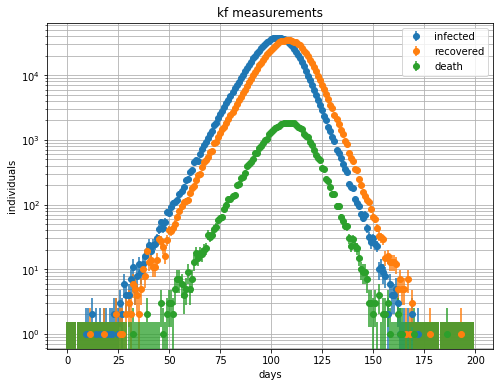

In [7]:
ms, ums        = us.kfmeas(ds)
usp.plt_kfmeas(ts, ms, ums)

### KF H-matrices - with susceptibles 

H-matrices are in this model diagonal, which implies that parameters are independent. They correspond to the prediction of delta of new infected, recovered and deaths using the infected individuals and the times of infection, recovery and death.

Let's conssider that $S(t)$, the susceptible cases is know. This is an accademic case. In that case, we can use $S(t)$ to compute the H-matrices, the predicitions, and the KF parameters is $\beta$, the infection global rate.

In the following cell we compute the KF H-matrices with $S$ known, and check that the predicion and the measurements are fine.

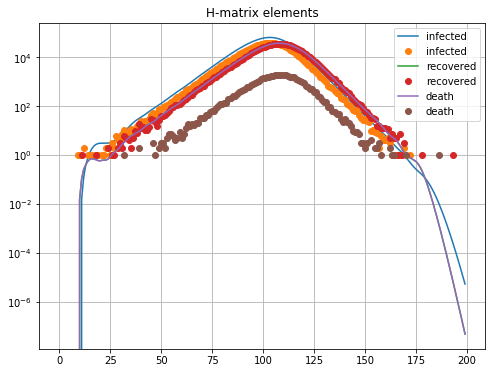

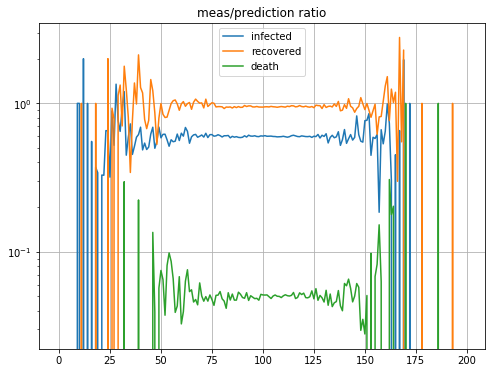

In [8]:
dios  = ds[0]
times = TI, TR, TM
hs   = us.kfhmatrices(ts, dios, times, sis = S/N)
usp.plt_kfhmatrices_check(ts, hs, ms);

### KF - global $\beta$

Let's now use the KF to compute $\beta, \phi_R, \Phi_M$ as a function of time. 

Consider now that we know the susceptible, $S(t)$. Therefore the KF filter and smoother computes a global $\beta$.


In [9]:
times    = TI, TR, TM
q0       = np.array((0., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0 = q0, sis = S/N, scale = False)

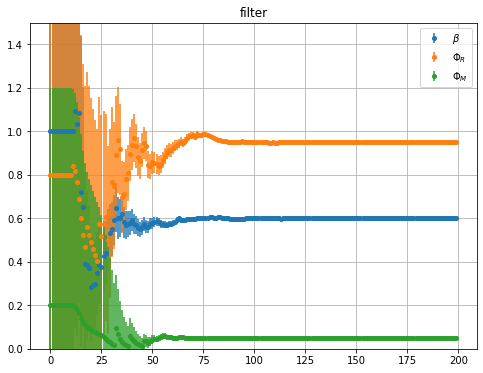

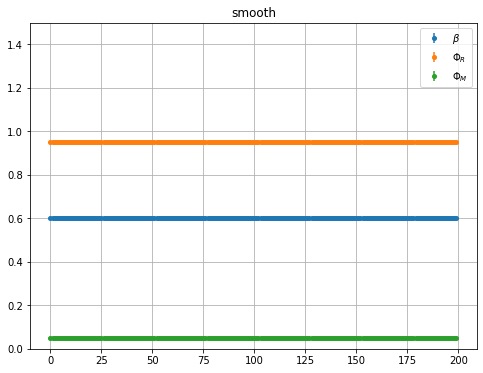

In [10]:
xm, uxm = xms
usp.plt_kfs(xm, uxm); plt.title('filter'); plt.ylim((0., 1.5))
xs, uxs = xss
usp.plt_kfs(xs, uxs); plt.title('smooth'); plt.ylim((0., 1.5));

### KF  - local $\beta$(t) - rate evolution

In reality we do not know $S(t)$. Therefore, the parameter $\beta(t)$ varies with time.

To use the KF to estimate $\beta(t)$ we can introduce an error, $q_0$, arbitrary large, between measurements, to allow $\beta(t)$ to change with time.


In [11]:
times    = TI, TR, TM
q0       = np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0 = q0, scale = False)

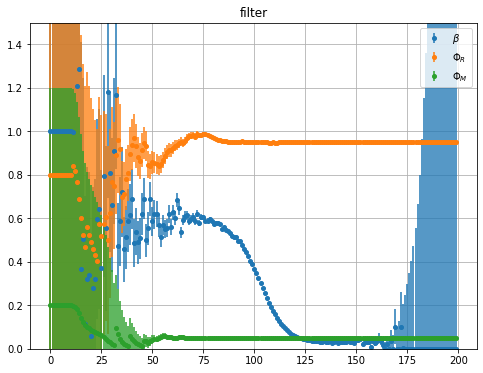

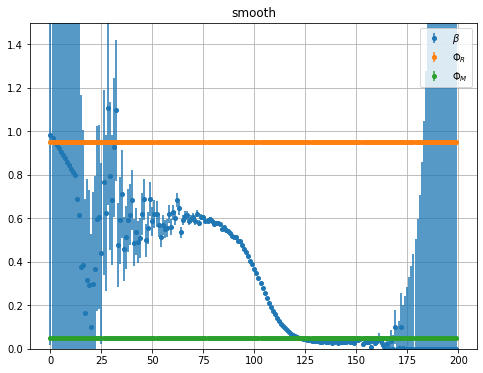

In [12]:
usp.plt_kfpars_time_evolution(xms, xss)

### check that $\beta$(t) follows $S(t)$

Let's check now that $\beta(t)$ estimated by the KT follows the relation, $\beta(t) = R_0/T_R S(t)/N$, with is time delay, $T_I$.

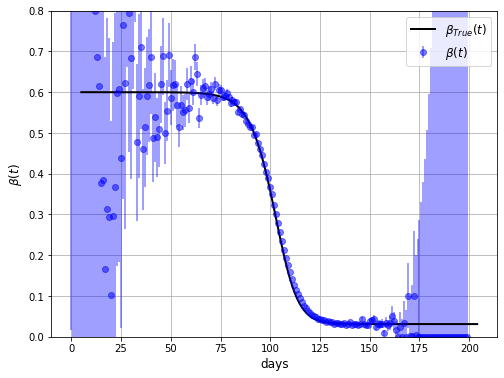

In [13]:
usp.plt_beta_time_evolution(xss, TI, R0/TR, S/N);
plt.xlabel('days', fontsize = 12); plt.ylabel(r"$\beta(t)$", fontsize = 12);

We conclude that KF estimate $\beta(t) = \beta \, S/N  = R_0 / T_R S/N$

### KF - local $\beta(t)$ - with normalized samples

We repeat the KF but now, instead of absolute number of new infected, recovered and death, we use normalized fractions of new infections, recovered and deaths.

Check that we compute properly $\beta(t)$

In [14]:
times    = TI, TR, TM
q0       = 1e0 * np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0 = q0, scale = True)

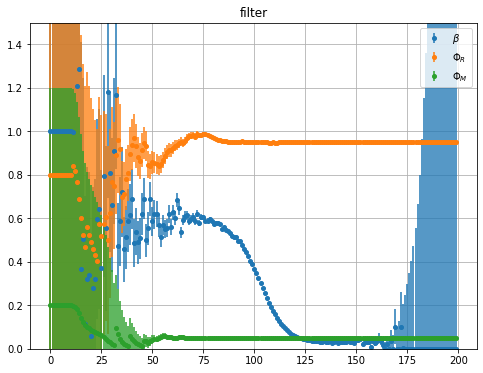

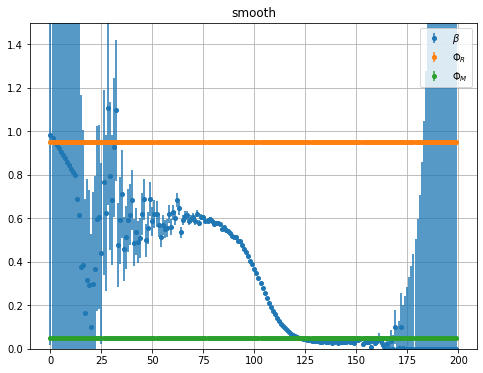

In [15]:
usp.plt_kfpars_time_evolution(xms, xss)

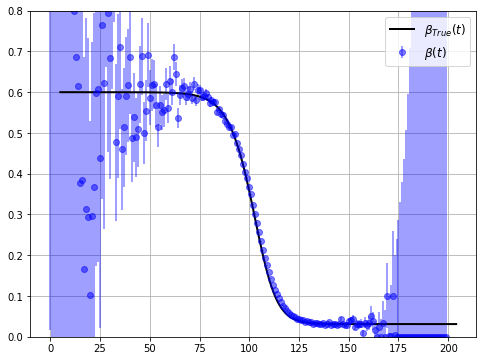

In [16]:
usp.plt_beta_time_evolution(xss, TI, R0/TR, S/N);

### KF - local $\beta(t)$ - Use death as proxy

In reality we do not know $S(t)$, neither $\Delta I_0(t)$, the new infections, neither $\Delta R$. The only quantity that we can measure is $\Delta M$, the increase of deaths.

We can use $\Delta M$ as a proxy for $\Delta I_0$, and check that we can still recover $\beta(t)$ now with a delay $T_M$

Now the parameters $\Phi_R, \Phi_M$ have no meaning.

In [17]:
times    = TI, TR, TM
q0       = 1e0 * np.array((1., 0., 0.))
dios, drs, dms = ds
ts       = np.arange(len(dms))
xss, xms = us.useir_kfs((dms, dms, dms), times, q0 = q0, scale = True)

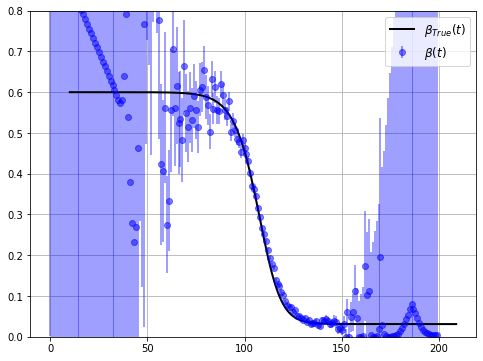

In [18]:
usp.plt_beta_time_evolution(xss, TR + TM, R0/TR, S/N);

## uSEIR - quenched

Let's consider now a pandemic that is quenched after some time, or when a fraction of the population has been infected. Social distance measures or a querentine are imposed to the population, adn the infection rate $\beta$ changes from $\beta$ to $\rho$ after the measures are inforced.

In this model we introduce two new parameters:

 - s1 : the fraction of the suceptible population that has been infected in the moment the quarentine is imposed.
 - $\rho$ : the infection rate after the quarentine 

Equivalent we can define two factors:

 - $R_0$ : The number of infected per infenction inidivual before the quarentine.
 - $R_1$ : the same after the quarentine.

In the following example, we consier that a quarentine is imposed after 15 % of the population is infected, and that the posterior rate, $R_0 = 3, \; R_1 = 0.85$ with removal time $T_R = 5$ days.

The pdf are poisson, and the infection and time to death are $T_I = 5, T_M = 7$ days.

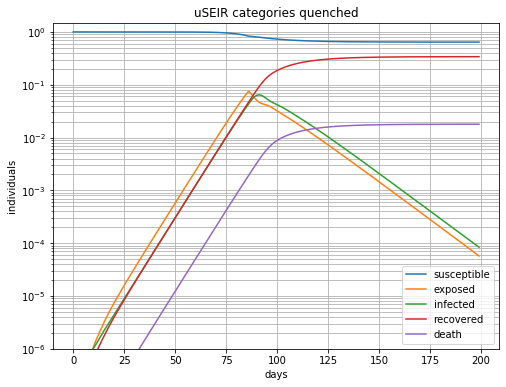

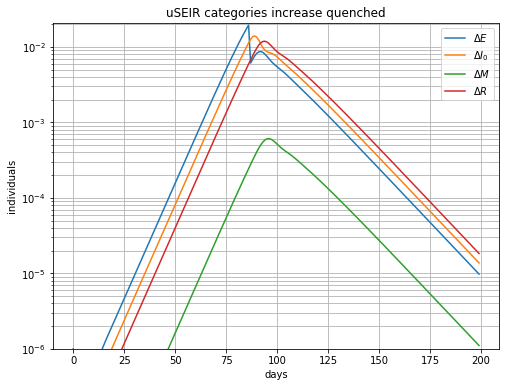

In [19]:
N               = 1e6
R0, TI, TR, TM  = 3., 5., 5., 7.
PhiM            = 0.05
ndays           = 200
rho             = 'poisson'
frho            = us.frho(rho)

S1, R1          = 0.15, 0.85
SS, DD          = us.uSEIRq(N, R0, TI, TR, TM, PhiM, S1, R1, ndays, rho)
S, E, I, R, M   = SS
DE, DI0, DR, DM = DD

ts = np.arange(ndays)
title = 'quenched'
usp.plt_uSEIR(ts, SS, DD, title, yscale = 'log', norma = True);

### generate data

In [20]:
ds = [us.mrvs(dx) for dx in (DI0, DR, DM)]

### KF - $\beta(t)$

We apply KF allowing $\beta(t)$ to change with time.


In [21]:
times    = TI, TR, TM
q0       = 1e4 * np.array((1., 0., 0.))
xss, xms = us.useir_kfs(ds, times, q0, scale = False)

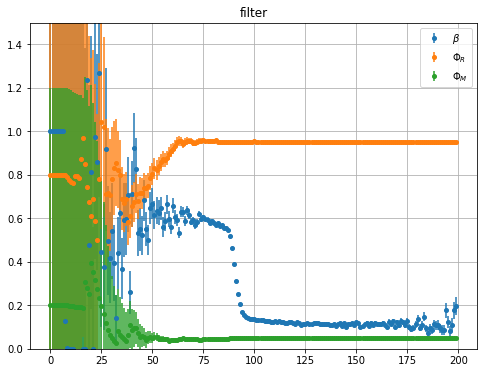

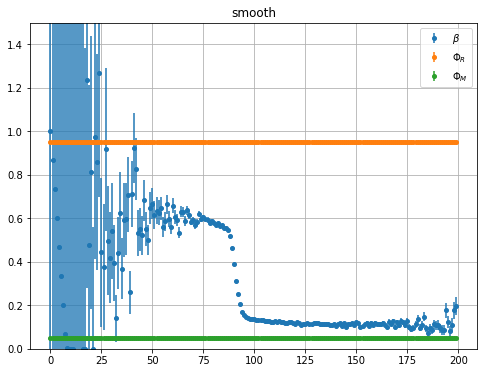

In [22]:
usp.plt_kfpars_time_evolution(xms, xss);

### check $\beta(t)$


Let's check now that $\beta(t)$ changes after the imposition of the quarentine, at time $t_Q$:

$$ \beta(t) =
  \begin{cases}
    R_0/T_R \, S(t)/N    &  t \le t_Q\\
    R_1/T_R \, S(t)/N   &  t > t_Q
  \end{cases}
$$




### KF $\beta$(t) - rate evolution

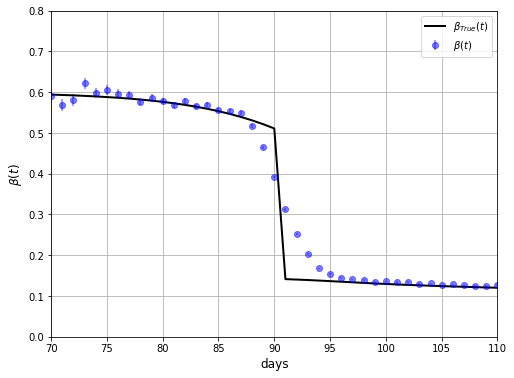

In [23]:
betas0, ubetas0, rr = usp.plt_betaq_time_evolution(xss, TR, R0/TR, R1/TR, S/N, S1)
plt.xlim((70, 110)); plt.xlabel('days', fontsize = 12); plt.ylabel(r'$\beta(t)$', fontsize = 12);

### Use death as a proxy

In [24]:
times    = TI, TR, TM
q0       = 10e0 * np.array((1., 0., 0.))
dios, drs, dms = ds
ts       = np.arange(len(dms))
xss, xms = us.useir_kfs((dms, dms, dms), times, q0 = q0, scale = True)

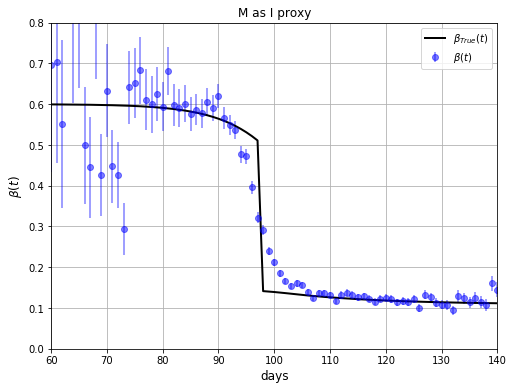

In [25]:
betas1, ubetas1, _ = usp.plt_betaq_time_evolution(xss, TR + TM, R0/TR, R1/TR, S/N, S1)
plt.xlim((60, 140)); plt.xlabel('days', fontsize = 12); plt.ylabel(r'$\beta(t)$', fontsize = 12);
plt.title('M as I proxy', fontsize = 12);

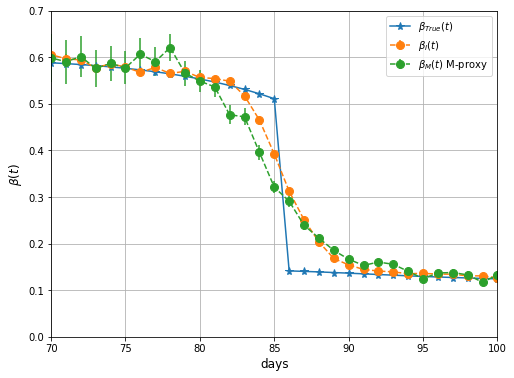

In [26]:
plt.figure(figsize = ((8, 6)))
plt.plot(ts, rr, marker = '*', ms = 8, label = r'$\beta_{True}(t)$')
plt.errorbar(ts - TR, betas0, yerr = ubetas0, ls = '--', marker = 'o', ms = 8, label = r'$\beta_{I}(t)$');
plt.errorbar(ts - TR - TM, betas1 , yerr = ubetas1, ls = '--', marker = 'o', ms = 8, label = r'$\beta_M(t)$ M-proxy');
plt.grid(); plt.ylim((0., 0.7)); plt.legend(); plt.xlim((70, 100));
plt.xlabel('days', fontsize = 12); plt.ylabel(r'$\beta(t)$', fontsize = 12);

## Conclusions

- KF (filter + smoother) with H-matrices with prediction of new-infected, recovered and deaths works. Needs as input the times: infection, recovery, and death, and the pdf (i.e gamma)

- If the susceptibles is known (accademic) the KF returns $\beta$, there infection rate

- If the susceptibles are not know (reality) the KF returns $\beta(t)$ that is shifted by the time of infection, $T_I$.

- KF follows $\beta$(t) for uSEIR-quenched pandemia. $\beta$ follows $R(t)/T \, S/N$ with a delay $T_I + T_R$
- The step in $\beta$(t) seems to be smoothed by $T_I + T_R$.